In [26]:
import sys
sys.path.append("..")

import pandas as pd

SAVE_DIR = "../../data"

file_criteo = SAVE_DIR + "/criteo-uplift-v2.1.csv"

df_criteo = pd.read_csv(file_criteo, sep=',')
df_criteo

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
random_state=20220720
df_criteo=df_criteo.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

In [ ]:
import numpy as np
# scale the feature values between 0 and 1
def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))

In [ ]:
T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['visit'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape

((13979592, 1), (13979592, 1), (13979592, 1))

In [ ]:
batch_size = int(len(X) * 0.7)

X_train = X[:batch_size, :]
T_train = T[:batch_size, :]
Y_visit_train = Y_visit[:batch_size, :]
Y_conv_train = Y_conv[:batch_size, :]

X_test = X[batch_size:, :]
T_test = T[batch_size:, :]
Y_visit_test = Y_visit[batch_size:, :]
Y_conv_test = Y_conv[batch_size:, :]

batch_size, X_train.shape, X_test.shape, T_train.shape

(9785714, (9785714, 12), (4193878, 12), (9785714, 1))

In [ ]:
sys.path.append("..")
from model.uplift_model import *
# here in uplift_model, there're self-defined methods include S-Learner, X-Learner, uplift_rank

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


import causalml
from causalml.metrics import *
import matplotlib.pyplot as plt


def get_causalml_auuc(Y, T, ite_pred, normalize=True):

    metric_df = pd.DataFrame([ite_pred.flatten(),
                               Y.flatten(),
                               T.flatten()]).T


    metric_df.columns=['model','y','w'] 
    uplift_rank_lift = get_cumlift(metric_df)

    normalize = True

    uplift_rank_gain = uplift_rank_lift.mul(uplift_rank_lift.index.values, axis=0)
    if normalize:
        uplift_rank_gain = uplift_rank_gain.div(np.abs(uplift_rank_gain.iloc[-1, :]), axis=1)
    uplift_rank_auuc_score = uplift_rank_gain.sum()/uplift_rank_gain.shape[0]
    
    print(uplift_rank_auuc_score)
    
    step = len(T) // 200 
    
    uplift_rank_gain.iloc[::step, :].plot()
    plt.show()
    
    return uplift_rank_auuc_score, uplift_rank_gain.iloc[::step, :]

d:\CodingProjects\code-uplift\AAAI2023-Code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
count = 20

In [ ]:
import sklearn 
import sklearn.metrics

slearner_causalml_auuc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_slearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/slearner/slearner_criteo_model_{}.h5'.format(i+1))
    Y_pre = final_model.predict([X_test, T_test])
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(Y_visit_test, Y_pre)
    print("auc"+str(sklearn.metrics.auc(fpr, tpr)))
    print("mse"+str(sklearn.metrics.mean_squared_error(Y_visit_test, Y_pre)))
    
    # creates two sets of predictions: one with treatment T0 (all zeros) and one with treatment T1 (all ones).
    # The difference between these two sets of predictions gives the estimated Individual Treatment Effects (ITE) for each instance.
    T0 = np.zeros(shape=T_test.shape)
    T1 = np.ones(shape=T_test.shape)

    p0 = final_model.predict([X_test,  T0])
    p1 = final_model.predict([X_test,  T1])

    # ITE = p1 - p0
    slearner_pre = p1 - p0
    
    slearner_causalml_auuc = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=slearner_pre)
    slearner_causalml_auuc_list.append(slearner_causalml_auuc)
    
    print("\n")

In [ ]:
xlearner_causalml_auuc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    
    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/xlearner_criteo_model_tau_0_{}.h5'.format(i+1))

    tau_0_pre = final_model.predict(X_test)

    final_model = get_xlearner_criteo_model()
    final_model.load_weights('../model_file/uplift/criteo/final_model/xlearner/xlearner_criteo_model_tau_1_{}.h5'.format(i+1))

    tau_1_pre = final_model.predict(X_test)

    ex = 0.85
    
    xlearner_tau_pre = ex * tau_0_pre + (1 - ex) * tau_1_pre

    xlearner_causalml_auuc = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=xlearner_tau_pre)
    
    xlearner_causalml_auuc_list.append(xlearner_causalml_auuc)
    
    print("\n")

#### 第三版：input_x再concat {0,1}

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

class shape(keras.Layer):
    def call(self, x):
        return tf.shape(x)
    
class CustomEndpointLayer(keras.layers.Layer):
    def __init__(self, alpha, name=None):
        super().__init__(name=name)
        self.alpha = alpha

    def call(self, inputs):
        y_true, input_t, selected_output, t1_y_pred, t0_y_pred = inputs

        # Prediction Loss
        pl_loss = tf.keras.losses.BinaryCrossentropy()(y_true, selected_output)

        # Decision Loss
        tau_hat = t1_y_pred - t0_y_pred
        p = tf.exp(tau_hat) / tf.reduce_sum(tf.exp(tau_hat)) # softmax(tau_hat)
        n1 = tf.reduce_sum(tf.cast(tf.equal(input_t, 1), tf.float32))
        n0 = tf.reduce_sum(tf.cast(tf.equal(input_t, 0), tf.float32))
        sum_t1 = tf.reduce_sum(tf.where(tf.equal(input_t, 1), p * y_true, tf.zeros_like(y_true)))
        sum_t0 = tf.reduce_sum(tf.where(tf.equal(input_t, 0), p * y_true, tf.zeros_like(y_true)))
        dl_loss = - (sum_t1 / n1 - sum_t0 / n0) * (n1 + n0) * 10

        total_loss = pl_loss + self.alpha * dl_loss
        
        self.add_loss(total_loss)

        #tf.print("pl_loss:", pl_loss)
        #tf.print("dl_loss:", dl_loss)
        

        return selected_output, t1_y_pred, t0_y_pred

In [ ]:
import tensorflow as tf
from keras import layers, regularizers, Model
from keras.layers import Input, Dense, Lambda


def XXXModel(alpha):
    input_x = Input(shape=(12,), name="features")
    input_t = Input(shape=(1,), name = "treatments")
    y_true = Input(shape=(1,), name = "y_true")

    zero_input = Lambda(lambda x: tf.zeros((x, 1), dtype=tf.float32), name='zero_input')(shape()(input_x)[0])
    one_input = Lambda(lambda x: tf.ones((x, 1), dtype=tf.float32), name='one_input')(shape()(input_x)[0])

    x_1 = layers.concatenate([input_x, one_input])
    x_0 = layers.concatenate([input_x, zero_input])

    shared_layer = Dense(8, activation='relu', name='shared_layer', kernel_regularizer=regularizers.l2(1e-5))
    
    shared_0 = shared_layer(x_0)
    shared_1 = shared_layer(x_1)

    t0_y_pred = Dense(1, name='t0_y_pred', activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5))(shared_0)
    t1_y_pred = Dense(1, name='t1_y_pred', activation='sigmoid', kernel_regularizer=regularizers.l2(1e-5))(shared_1)

    selected_output = layers.Lambda(lambda x: tf.where(tf.equal(x[0], 1), x[1], x[2]), name='selected_output')([input_t, t1_y_pred, t0_y_pred])

    endpoint_layer = CustomEndpointLayer(alpha, name='custom_endpoint')([y_true, input_t, selected_output, t1_y_pred, t0_y_pred])

    XXX_model = Model(inputs=[input_x, input_t, y_true], outputs=endpoint_layer)

    return XXX_model


In [ ]:
# 模型和训练参数
import os

batch_size = 500000
alpha = tf.constant([0.85, 0.9, 0.95], dtype=tf.float32)
learning_rate = 0.005
epochs = 1000

model_save_dir = "../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/"
os.makedirs(model_save_dir, exist_ok=True)

In [ ]:
final_model = XXXModel(alpha)
final_model.compile(optimizer='adam')

final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shape_1 (shape)     │ (2)               │          0 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shape (shape)       │ (2)               │          0 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ ()                │          0 │ shape_1[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ ()                │          0 │ shape[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ one_input (Lambda)  │ (None, 1)         │          0 │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_input (Lambda) │ (None, 1)         │          0 │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 13)        │          0 │ features[0][0],   │
│ (Concatenate)       │                   │            │ one_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 13)        │          0 │ features[0][0],   │
│ (Concatenate)       │                   │            │ zero_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 8)         │        112 │ concatenate_1[0]… │
│ (Dense)             │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatments          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ t1_y_pred (Dense)   │ (None, 1)         │          9 │ shared_layer[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ t0_y_pred (Dense)   │ (None, 1)         │          9 │ shared_layer[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y_true (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ selected_output     │ (None, 1)         │          0 │ treatments[0][0], │
│ (Lambda)            │                   │            │ t1_y_pred[0][0],  │
│                     │                   │            │ t0_y_pred[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_endpoint     │ [(None, 1),       │          0 │ y_true[0][0],     │
│ (CustomEndpointLay… │ (None, 1), (None, │            │ treatments[0][0], │
│                     │ 1)]               │            │ selected_output[… │
│                     │                   │            │ t1_y_pred[0][0],  │
│                     │                   │            │ t0_y_pred[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 130 (520.00 B)

 Trainable params: 130 (520.00 B)

 Non-trainable params: 0 (0.00 B)


--- total_loss = pl_loss + 0.85 * dl_loss ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 2.3744 - val_loss: 1.9131
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.8047 - val_loss: 1.4477
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.3743 - val_loss: 1.1251
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.0861 - val_loss: 0.8958
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.8650 - val_loss: 0.7254
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.7128 - val_loss: 0.6063
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6050 - val_loss: 0.5187
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.5132 - val_loss: 0.4486
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.4588 - val_loss: 0.3920
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3845 - val_loss: 0.3462
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.3516 - val_loss: 0

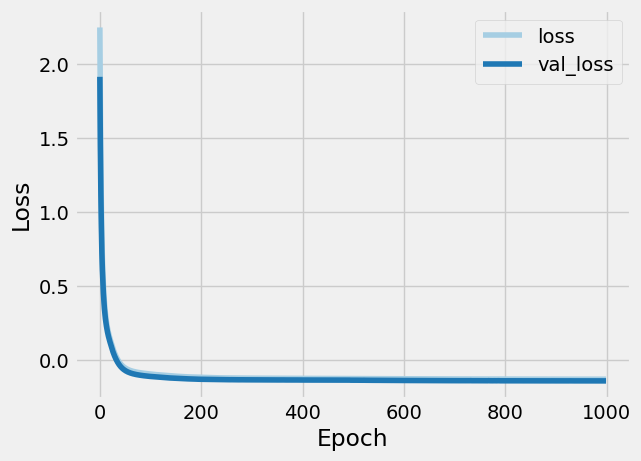


--- total_loss = pl_loss + 0.90 * dl_loss ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 2.0947 - val_loss: 1.8574
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.8036 - val_loss: 1.5885
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.5461 - val_loss: 1.3387
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.3011 - val_loss: 1.1123
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0763 - val_loss: 0.8850
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.8541 - val_loss: 0.7037
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.6808 - val_loss: 0.5692
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.5528 - val_loss: 0.4701
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.4646 - val_loss: 0.3970
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.4079 - val_loss: 0.3418
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3567 - val_loss: 0

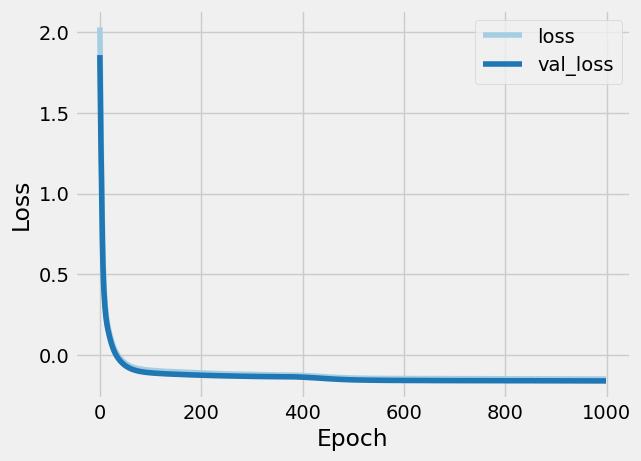


--- total_loss = pl_loss + 0.95 * dl_loss ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 1.7459 - val_loss: 1.4895
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.4240 - val_loss: 1.1657
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.1089 - val_loss: 0.8837
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.8441 - val_loss: 0.6746
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.6542 - val_loss: 0.5307
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.5159 - val_loss: 0.4272
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.4272 - val_loss: 0.3509
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.3572 - val_loss: 0.2933
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.2964 - val_loss: 0.2479
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.2498 - val_loss: 0.2102
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2080 - val_loss: 0

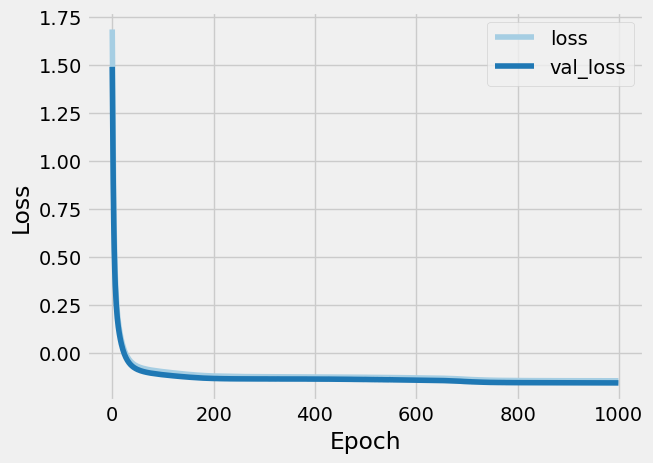

In [ ]:
# 训练循环
from keras.callbacks import ModelCheckpoint

for a in alpha:
    print(f"\n--- total_loss = pl_loss + {a:.2f} * dl_loss ---")

    final_model = XXXModel(alpha)
    final_model.compile(optimizer='adam')

    mcp_save = ModelCheckpoint(
        os.path.join(model_save_dir, f'xxx_{a:.2f}.weights.h5'),
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        save_weights_only=True
    )

    history = final_model.fit(
        [X_train, T_train, Y_visit_train],
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.2,
        verbose=1,
        callbacks=[mcp_save]
    )

    plot_loss(history, "loss", "val_loss")


--- total_loss = pl_loss + 0.8 * dl_loss ---

--- Iteration 1 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 1.0229 - val_loss: 0.8654
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8395 - val_loss: 0.7261
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.7152 - val_loss: 0.6246
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6193 - val_loss: 0.5447
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5388 - val_loss: 0.4796
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4699 - val_loss: 0.4241
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4280 - val_loss: 0.3769
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3810 - val_loss: 0.3359
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3502 - val_loss: 0.3004
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3069 - val_loss: 0.2698
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 

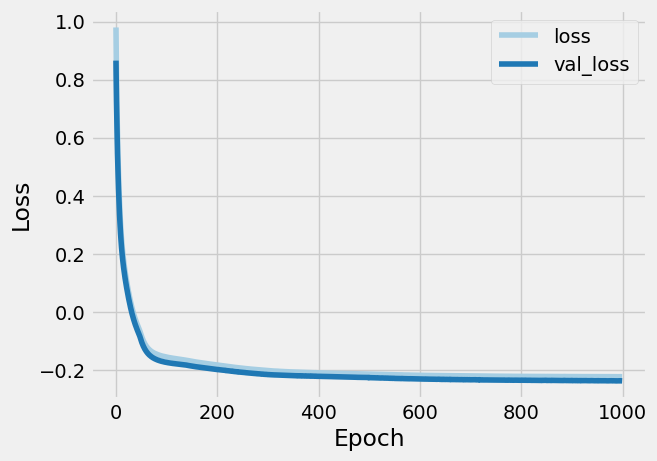


--- Iteration 2 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 1.6960 - val_loss: 1.4459
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.3991 - val_loss: 1.2027
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.1742 - val_loss: 1.0101
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.9847 - val_loss: 0.8383
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8203 - val_loss: 0.6693
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6530 - val_loss: 0.5366
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5206 - val_loss: 0.4361
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.4350 - val_loss: 0.3575
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3603 - val_loss: 0.2879
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2971 - val_loss: 0.2346
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2437 - val_loss: 0.1957
Epoch 12/1000
16/16 

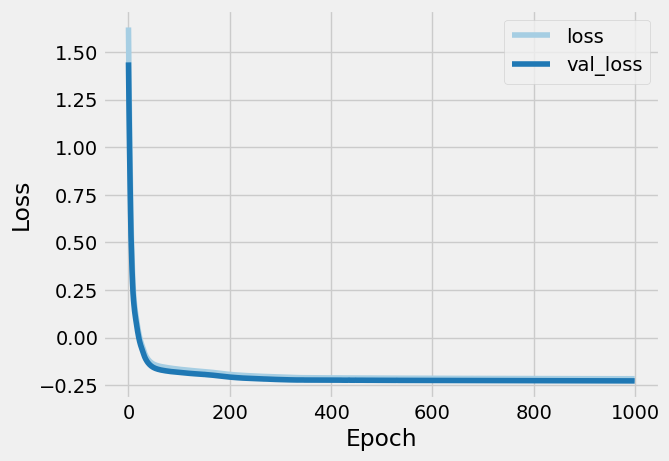


--- Iteration 3 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 1.4805 - val_loss: 1.3133
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 1.2846 - val_loss: 1.1304
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 1.1069 - val_loss: 0.9776
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.9513 - val_loss: 0.8518
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.8442 - val_loss: 0.7376
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.7297 - val_loss: 0.6259
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.6217 - val_loss: 0.5242
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.5151 - val_loss: 0.4351
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.4288 - val_loss: 0.3598
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.3668 - val_loss: 0.3007
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.3054 - val_loss: 0.2603
Epoch 12/1

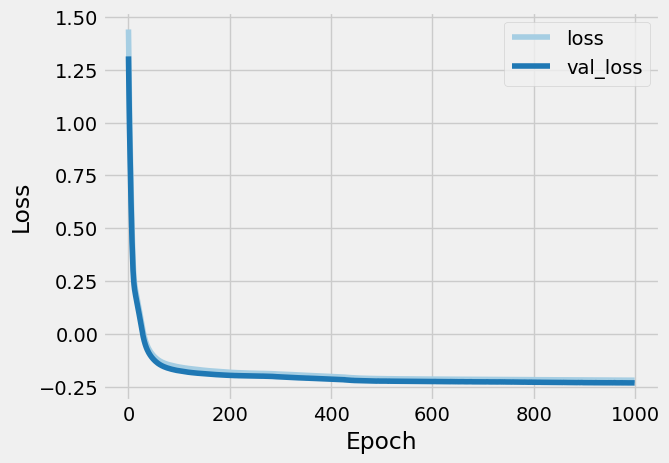


--- Iteration 4 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 2.2132 - val_loss: 1.9294
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.8745 - val_loss: 1.6567
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.6161 - val_loss: 1.4201
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.3812 - val_loss: 1.1821
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.1498 - val_loss: 0.9882
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.9720 - val_loss: 0.8384
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.8211 - val_loss: 0.7056
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6969 - val_loss: 0.5887
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5797 - val_loss: 0.4863
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.4895 - val_loss: 0.4026
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3985 - val_loss: 0.3383
Epoch 12/1000
16/16 

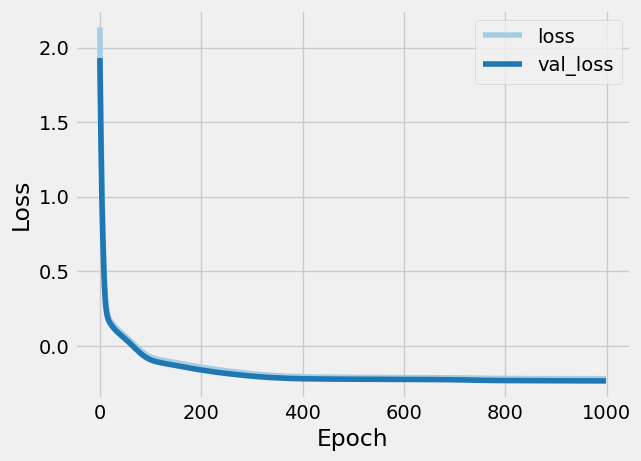


--- Iteration 5 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.1161 - val_loss: 1.7070
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.6237 - val_loss: 1.2962
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.2325 - val_loss: 1.0121
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.9734 - val_loss: 0.8124
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.7847 - val_loss: 0.6652
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6490 - val_loss: 0.5537
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5515 - val_loss: 0.4685
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4675 - val_loss: 0.4029
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4088 - val_loss: 0.3517
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3642 - val_loss: 0.3111
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.3211 - val_loss: 0.2783
Epoch 12/1000
16/16 

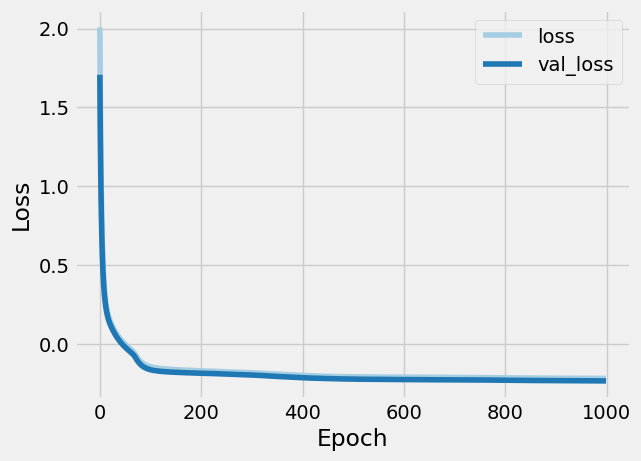


--- Iteration 6 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.4278 - val_loss: 1.2900
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.2665 - val_loss: 1.1547
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.1455 - val_loss: 1.0229
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0080 - val_loss: 0.8882
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.8750 - val_loss: 0.7341
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7009 - val_loss: 0.5907
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5774 - val_loss: 0.4766
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.4686 - val_loss: 0.3902
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.3921 - val_loss: 0.3263
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3376 - val_loss: 0.2792
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2863 - val_loss: 0.2446
Epoch 12/1000
16/16 

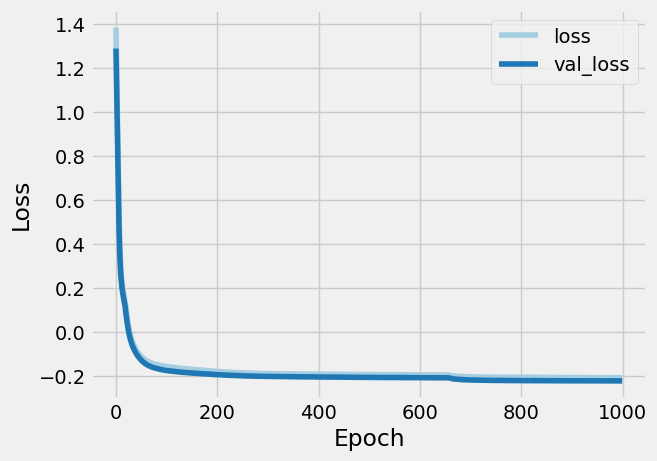


--- Iteration 7 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 2.1796 - val_loss: 2.0097
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.9875 - val_loss: 1.8303
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.8105 - val_loss: 1.6602
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.6253 - val_loss: 1.4683
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.4432 - val_loss: 1.2750
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.2483 - val_loss: 1.0699
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.0432 - val_loss: 0.8863
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.8661 - val_loss: 0.7340
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.7208 - val_loss: 0.6106
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5992 - val_loss: 0.5090
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5077 - val_loss: 0.4259
Epoch 12/1000
16/16 

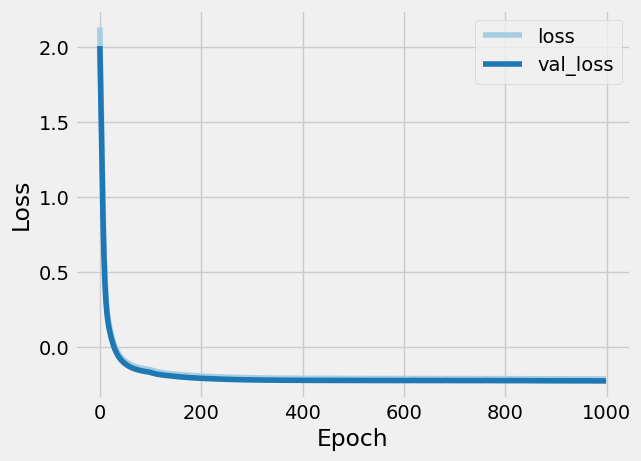


--- Iteration 8 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.6636 - val_loss: 0.5240
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.5090 - val_loss: 0.3896
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3864 - val_loss: 0.2901
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.2758 - val_loss: 0.2181
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.2277 - val_loss: 0.1785
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1945 - val_loss: 0.1598
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1730 - val_loss: 0.1493
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1659 - val_loss: 0.1415
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1623 - val_loss: 0.1347
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.1483 - val_loss: 0.1284
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1405 - val_loss: 0.1224
Epoch 12/1000
16/16 

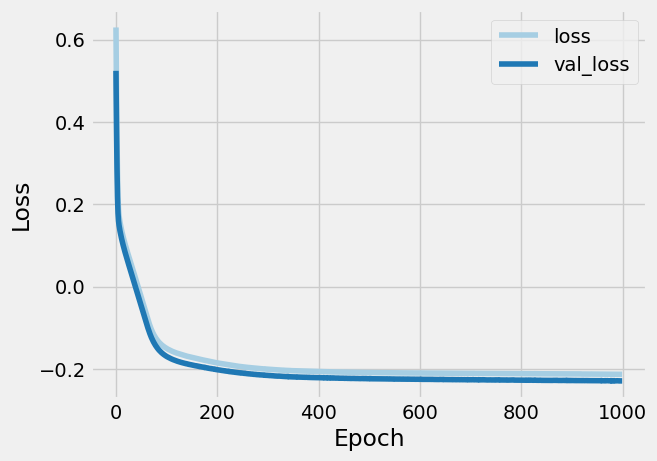


--- Iteration 9 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.3188 - val_loss: 2.0780
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.0315 - val_loss: 1.8272
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7970 - val_loss: 1.6148
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.5897 - val_loss: 1.4036
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.3728 - val_loss: 1.2188
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.1954 - val_loss: 1.0569
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0322 - val_loss: 0.9182
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.9077 - val_loss: 0.7995
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7801 - val_loss: 0.6965
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6907 - val_loss: 0.6068
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6019 - val_loss: 0.5288
Epoch 12/1000
16/16 

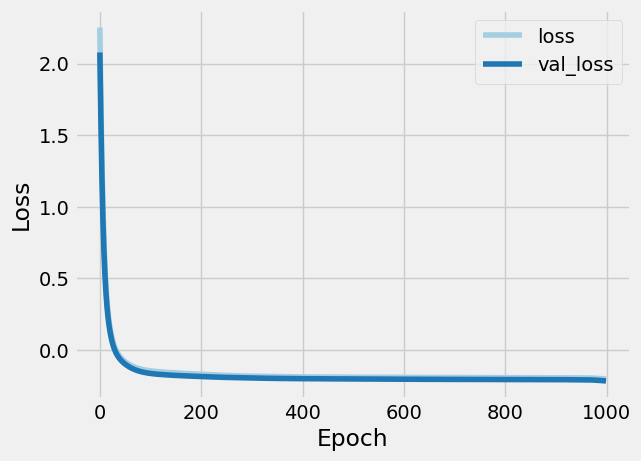


--- Iteration 10 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 2.2982 - val_loss: 2.0876
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.0545 - val_loss: 1.9197
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.9004 - val_loss: 1.7927
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7863 - val_loss: 1.7016
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7026 - val_loss: 1.6514
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.6605 - val_loss: 1.6112
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.6196 - val_loss: 1.5747
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.5809 - val_loss: 1.5375
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.5567 - val_loss: 1.4841
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.4841 - val_loss: 1.4054
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.4016 - val_loss: 1.3071
Epoch 12/1000
16/16

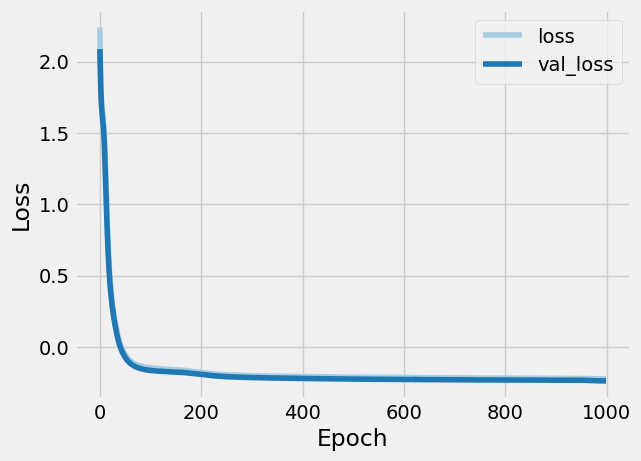


--- total_loss = pl_loss + 1.0 * dl_loss ---

--- Iteration 1 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.4657 - val_loss: 3.1140
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 3.0348 - val_loss: 2.7638
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.7182 - val_loss: 2.4939
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.4604 - val_loss: 2.2782
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.2631 - val_loss: 2.1148
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.1006 - val_loss: 1.9977
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.9930 - val_loss: 1.9021
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.8964 - val_loss: 1.8204
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.8179 - val_loss: 1.7501
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.7555 - val_loss: 1.6905
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 

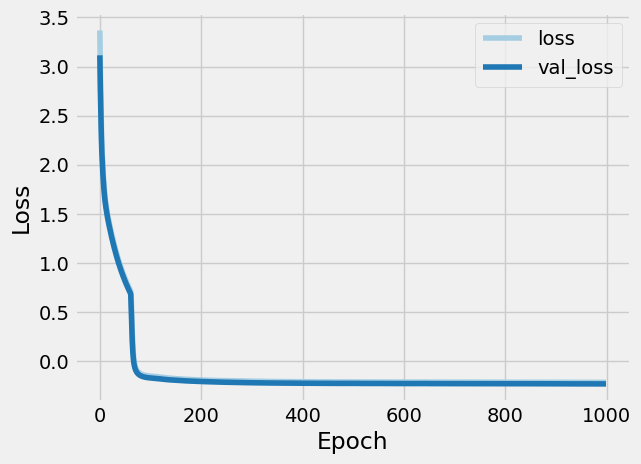


--- Iteration 2 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 1.3522 - val_loss: 1.0760
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.0168 - val_loss: 0.8294
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.7993 - val_loss: 0.6578
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6430 - val_loss: 0.5430
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5368 - val_loss: 0.4674
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.4717 - val_loss: 0.4129
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4169 - val_loss: 0.3702
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3774 - val_loss: 0.3345
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3444 - val_loss: 0.3037
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3143 - val_loss: 0.2768
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2856 - val_loss: 0.2531
Epoch 12/1000
16/16 

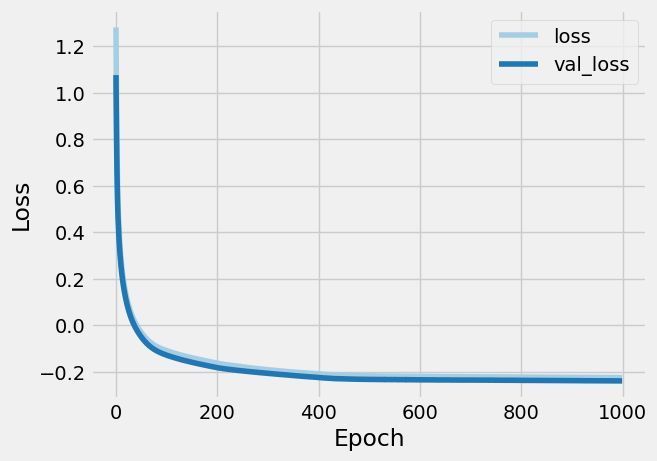


--- Iteration 3 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.9114 - val_loss: 1.7646
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.7515 - val_loss: 1.5995
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.5786 - val_loss: 1.4380
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.4186 - val_loss: 1.2672
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.2490 - val_loss: 1.1028
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.0849 - val_loss: 0.9536
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9443 - val_loss: 0.8188
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8122 - val_loss: 0.6957
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6887 - val_loss: 0.5936
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5868 - val_loss: 0.5058
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5045 - val_loss: 0.4314
Epoch 12/1000
16/16 

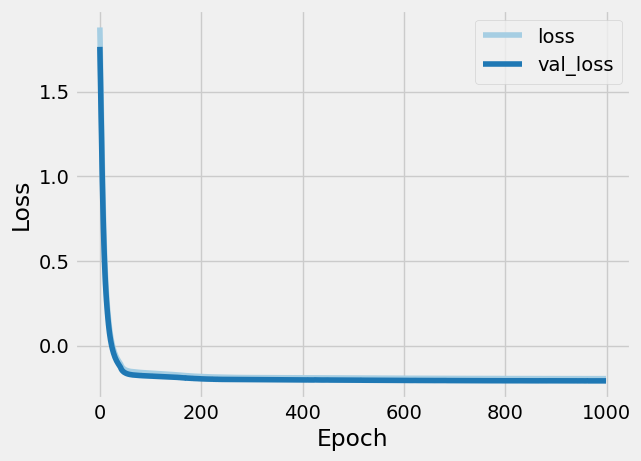


--- Iteration 4 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 1.9138 - val_loss: 1.6235
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.5631 - val_loss: 1.3076
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.2585 - val_loss: 1.0398
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9933 - val_loss: 0.7847
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.7555 - val_loss: 0.5755
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5558 - val_loss: 0.4283
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4214 - val_loss: 0.3314
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3247 - val_loss: 0.2669
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2627 - val_loss: 0.2224
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2293 - val_loss: 0.1898
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1904 - val_loss: 0.1643
Epoch 12/1000
16/16 

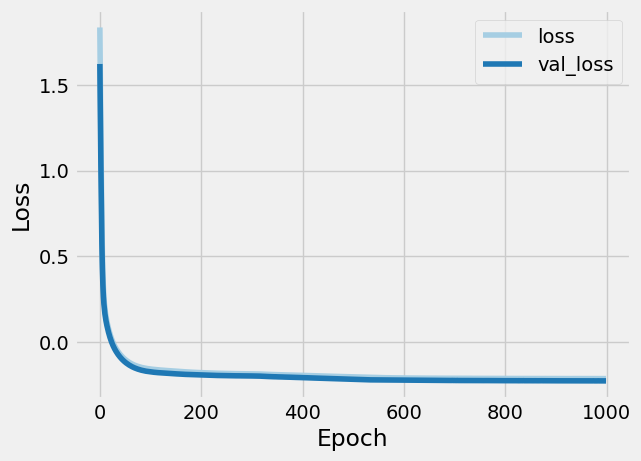


--- Iteration 5 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 1.2730 - val_loss: 1.0695
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.0353 - val_loss: 0.8827
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8603 - val_loss: 0.7229
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7062 - val_loss: 0.5844
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5756 - val_loss: 0.4777
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4687 - val_loss: 0.3985
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4003 - val_loss: 0.3403
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3460 - val_loss: 0.2974
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2995 - val_loss: 0.2657
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2663 - val_loss: 0.2419
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2528 - val_loss: 0.2238
Epoch 12/1000
16/16 

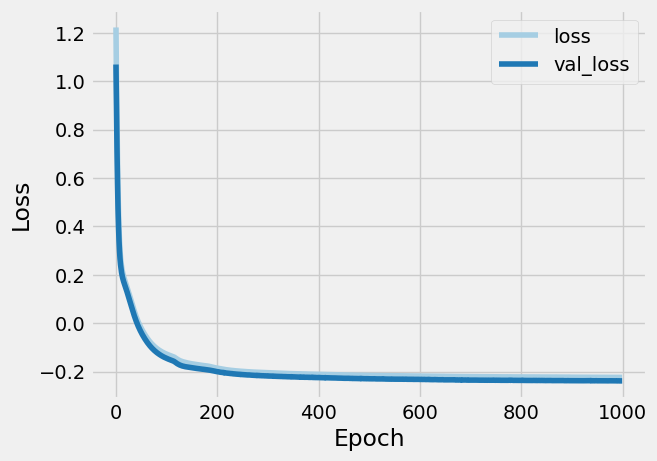


--- Iteration 6 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.9807 - val_loss: 0.8082
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.7933 - val_loss: 0.6348
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6209 - val_loss: 0.5026
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5009 - val_loss: 0.4068
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4031 - val_loss: 0.3383
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3441 - val_loss: 0.2902
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3025 - val_loss: 0.2567
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2732 - val_loss: 0.2330
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2447 - val_loss: 0.2159
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2317 - val_loss: 0.2030
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2272 - val_loss: 0.1929
Epoch 12/1000
16/16 

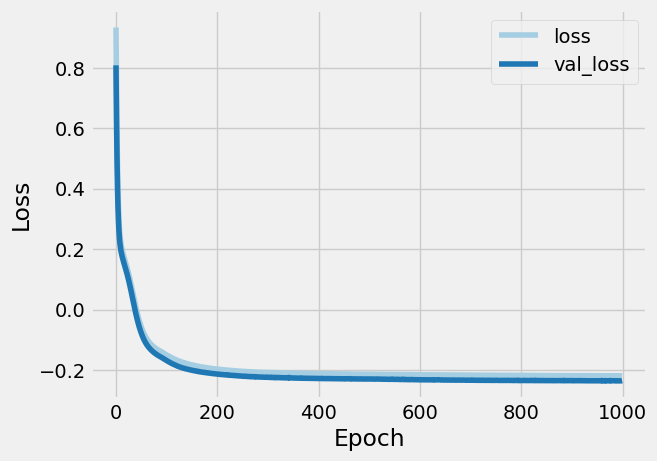


--- Iteration 7 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 1.7782 - val_loss: 1.5828
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 1.5561 - val_loss: 1.3688
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.3372 - val_loss: 1.1887
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.1714 - val_loss: 1.0585
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.0469 - val_loss: 0.9348
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.9188 - val_loss: 0.8134
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8052 - val_loss: 0.6984
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6884 - val_loss: 0.5933
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5949 - val_loss: 0.5006
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4996 - val_loss: 0.4209
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4236 - val_loss: 0.3534
Epoch 12/1000
16/16 

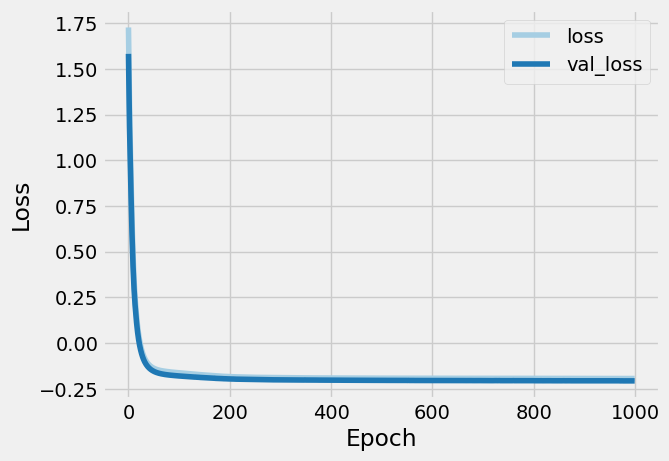


--- Iteration 8 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.8235 - val_loss: 0.6432
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6143 - val_loss: 0.4948
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4871 - val_loss: 0.4002
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4048 - val_loss: 0.3364
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3449 - val_loss: 0.2913
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2928 - val_loss: 0.2583
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2595 - val_loss: 0.2329
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2436 - val_loss: 0.2115
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2311 - val_loss: 0.1894
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2051 - val_loss: 0.1704
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.1843 - val_loss: 0.1568
Epoch 12/1000
16/16 

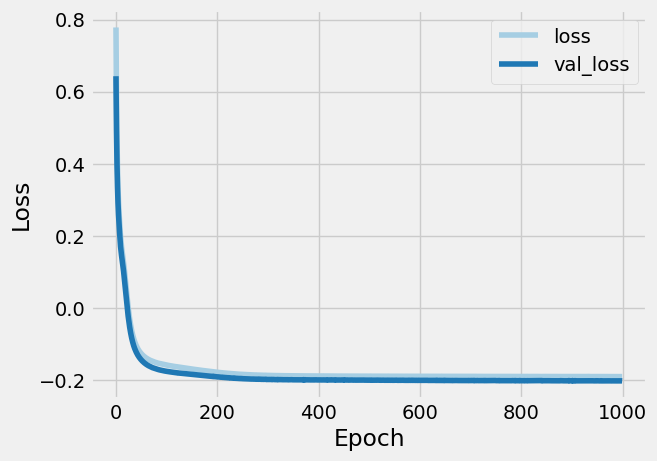


--- Iteration 9 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.2371 - val_loss: 1.0991
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.0860 - val_loss: 1.0058
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9994 - val_loss: 0.9543
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.9631 - val_loss: 0.9129
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9196 - val_loss: 0.8752
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8808 - val_loss: 0.8401
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8450 - val_loss: 0.8071
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8202 - val_loss: 0.7758
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7923 - val_loss: 0.7457
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.7488 - val_loss: 0.7166
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7297 - val_loss: 0.6885
Epoch 12/1000
16/16 

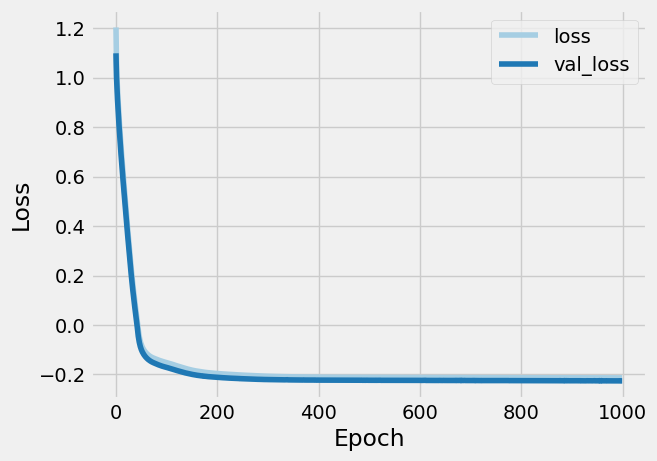


--- Iteration 10 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 1.1296 - val_loss: 0.9135
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.8811 - val_loss: 0.7050
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6865 - val_loss: 0.5641
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5565 - val_loss: 0.4663
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4617 - val_loss: 0.3925
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3974 - val_loss: 0.3362
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3423 - val_loss: 0.2935
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.3011 - val_loss: 0.2606
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2715 - val_loss: 0.2350
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2517 - val_loss: 0.2151
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2261 - val_loss: 0.1991
Epoch 12/1000
16/16

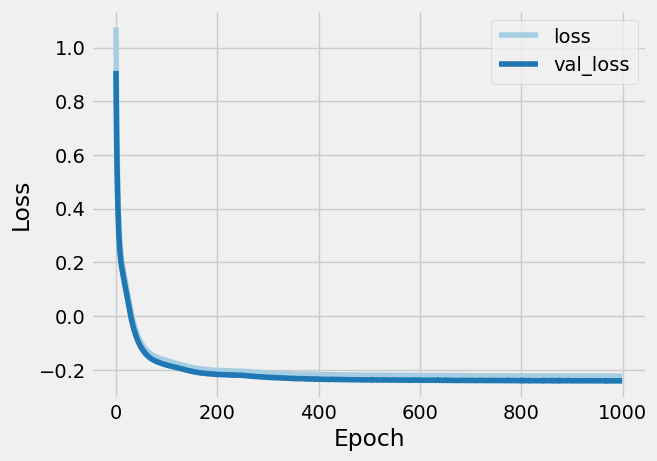


--- total_loss = pl_loss + 1.2 * dl_loss ---

--- Iteration 1 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 3.4266 - val_loss: 3.0290
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.9515 - val_loss: 2.6772
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.6266 - val_loss: 2.3648
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.2770 - val_loss: 1.9527
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.8797 - val_loss: 1.6018
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.5408 - val_loss: 1.3281
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.2876 - val_loss: 1.1139
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.0824 - val_loss: 0.9480
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.9417 - val_loss: 0.8185
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8079 - val_loss: 0.7145
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 

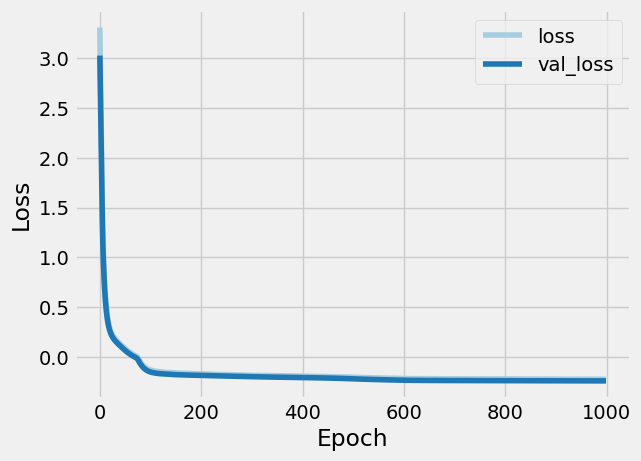


--- Iteration 2 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.1118 - val_loss: 0.9284
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.8868 - val_loss: 0.7164
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6898 - val_loss: 0.5495
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5410 - val_loss: 0.4339
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4361 - val_loss: 0.3575
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.3628 - val_loss: 0.3062
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2987 - val_loss: 0.2697
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2780 - val_loss: 0.2433
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2572 - val_loss: 0.2236
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2431 - val_loss: 0.2078
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.2142 - val_loss: 0.1944
Epoch 12/1000
16/16 

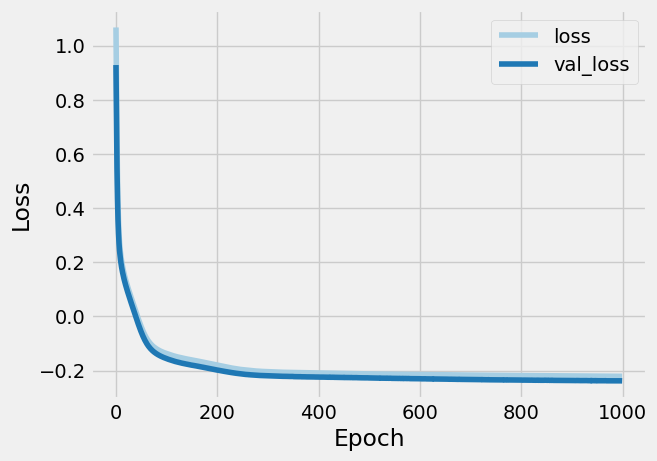


--- Iteration 3 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.3371 - val_loss: 1.1843
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.1613 - val_loss: 1.0359
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.0149 - val_loss: 0.9139
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.8987 - val_loss: 0.8093
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8105 - val_loss: 0.7150
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.7076 - val_loss: 0.6314
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6290 - val_loss: 0.5584
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5576 - val_loss: 0.4951
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.4996 - val_loss: 0.4405
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4429 - val_loss: 0.3937
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3950 - val_loss: 0.3537
Epoch 12/1000
16/16 

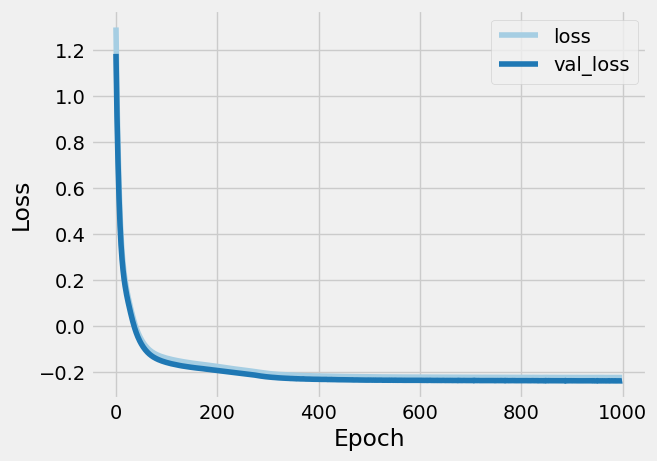


--- Iteration 4 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.8002 - val_loss: 1.5930
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.5466 - val_loss: 1.3775
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.3432 - val_loss: 1.1982
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.1768 - val_loss: 1.0470
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.0320 - val_loss: 0.9029
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.8879 - val_loss: 0.7453
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.7204 - val_loss: 0.6006
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5856 - val_loss: 0.4775
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4712 - val_loss: 0.3836
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3831 - val_loss: 0.3149
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3206 - val_loss: 0.2659
Epoch 12/1000
16/16 

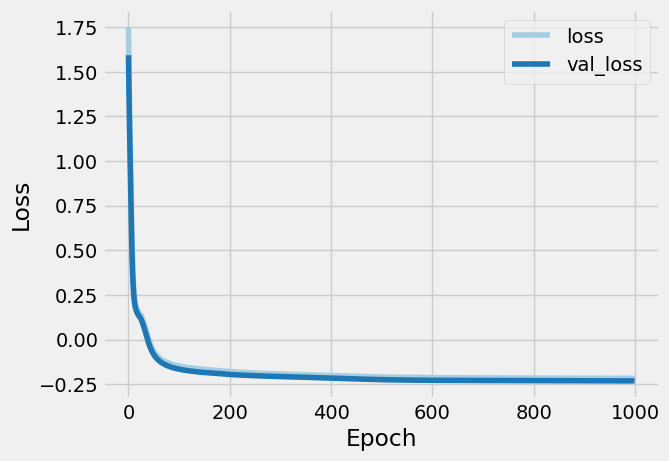


--- Iteration 5 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 5.6133 - val_loss: 5.0922
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 4.9634 - val_loss: 4.4735
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 4.3441 - val_loss: 3.8609
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.7388 - val_loss: 3.2720
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 3.1477 - val_loss: 2.6905
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.5771 - val_loss: 2.1537
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.0613 - val_loss: 1.7385
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.6715 - val_loss: 1.4266
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.3758 - val_loss: 1.1924
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.1602 - val_loss: 1.0146
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.0022 - val_loss: 0.8762
Epoch 12/1000
16/16 

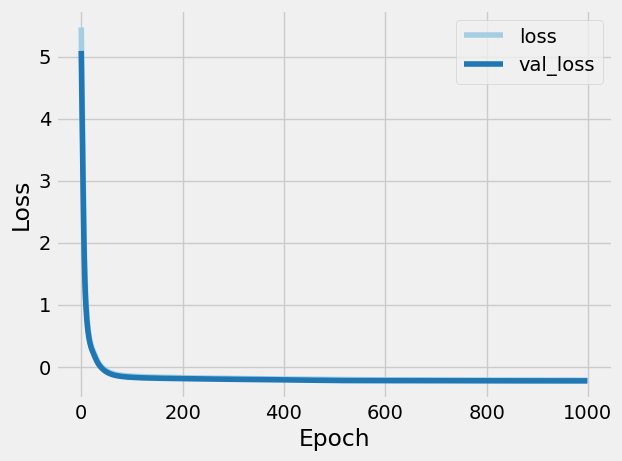


--- Iteration 6 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.3233 - val_loss: 1.0946
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.0485 - val_loss: 0.8890
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.8707 - val_loss: 0.7366
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.7232 - val_loss: 0.6209
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6214 - val_loss: 0.5304
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5189 - val_loss: 0.4567
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.4597 - val_loss: 0.3964
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4062 - val_loss: 0.3472
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3591 - val_loss: 0.3073
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.3248 - val_loss: 0.2750
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2890 - val_loss: 0.2485
Epoch 12/1000
16/16 

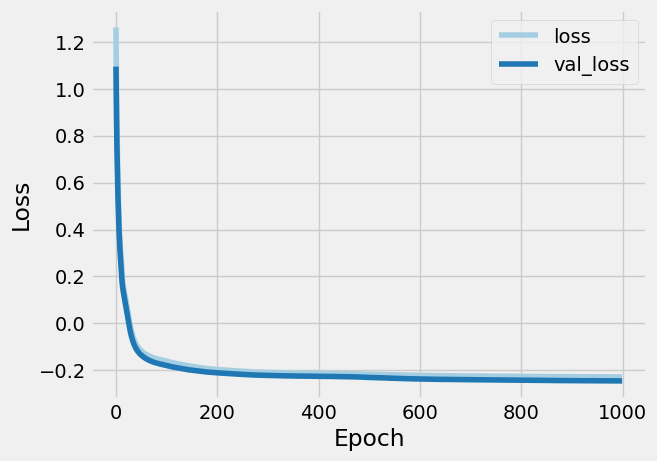


--- Iteration 7 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.8297 - val_loss: 1.5807
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.5167 - val_loss: 1.2590
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.2123 - val_loss: 0.9904
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.9427 - val_loss: 0.7785
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.7542 - val_loss: 0.6157
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6035 - val_loss: 0.4911
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4854 - val_loss: 0.3952
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3980 - val_loss: 0.3287
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3278 - val_loss: 0.2823
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2852 - val_loss: 0.2493
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2579 - val_loss: 0.2258
Epoch 12/1000
16/16 

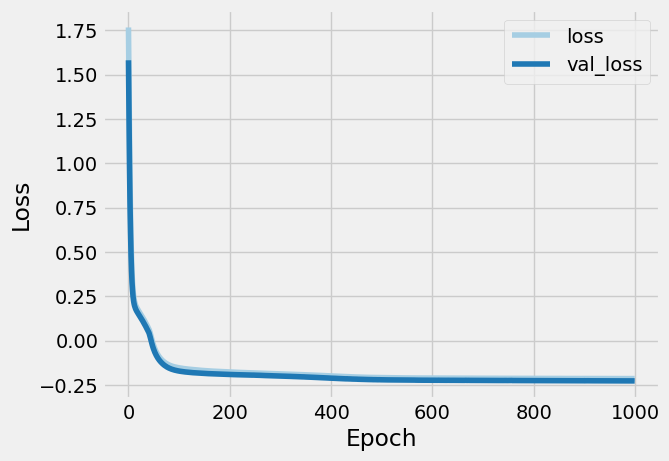


--- Iteration 8 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.2186 - val_loss: 2.0596
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.0353 - val_loss: 1.8835
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.8697 - val_loss: 1.7148
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.6845 - val_loss: 1.5529
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.5316 - val_loss: 1.3849
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.3406 - val_loss: 1.1473
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.1164 - val_loss: 0.9392
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.9237 - val_loss: 0.7770
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.7522 - val_loss: 0.6514
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6440 - val_loss: 0.5538
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5460 - val_loss: 0.4773
Epoch 12/1000
16/16 

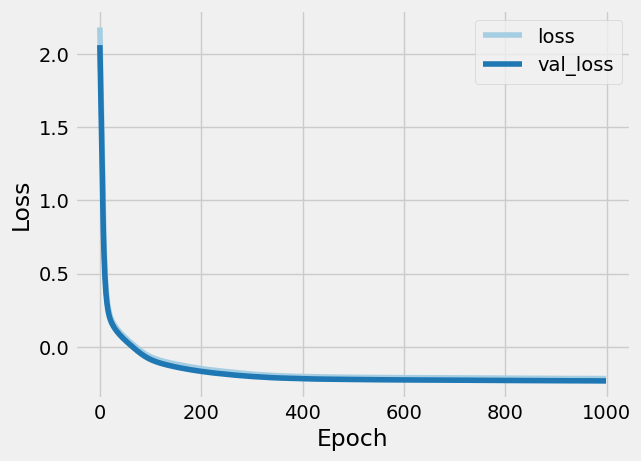


--- Iteration 9 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.2967 - val_loss: 1.1499
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1247 - val_loss: 0.9656
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.9409 - val_loss: 0.8017
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.7873 - val_loss: 0.6557
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6521 - val_loss: 0.5318
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.5145 - val_loss: 0.4292
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.4175 - val_loss: 0.3445
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3447 - val_loss: 0.2857
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2942 - val_loss: 0.2379
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2521 - val_loss: 0.2079
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2200 - val_loss: 0.1908
Epoch 12/1000
16/16 

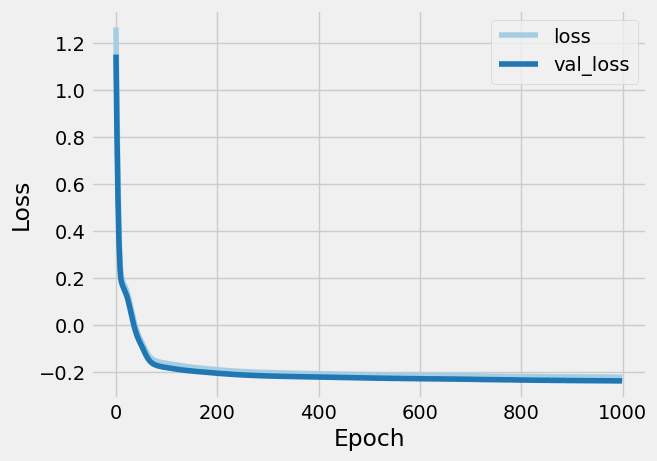


--- Iteration 10 ---
Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.4663 - val_loss: 1.2289
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.1783 - val_loss: 0.9724
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.9447 - val_loss: 0.7760
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.7531 - val_loss: 0.6097
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6018 - val_loss: 0.4854
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4735 - val_loss: 0.3890
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.3854 - val_loss: 0.3120
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.3123 - val_loss: 0.2612
Epoch 9/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.2647 - val_loss: 0.2247
Epoch 10/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2357 - val_loss: 0.1961
Epoch 11/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2097 - val_loss: 0.1724
Epoch 12/1000
16/16

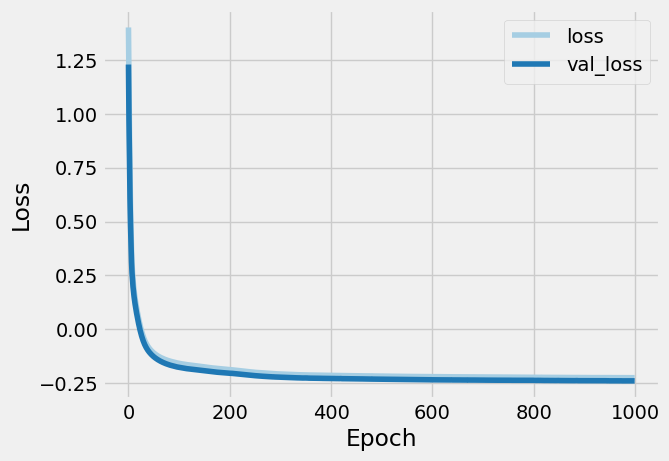

In [ ]:
# 训练循环
from keras.callbacks import ModelCheckpoint

for a in alpha:
    print(f"\n--- total_loss = pl_loss + {a:.1f} * dl_loss ---")

    for iteration in range(count):
        print(f"\n--- Iteration {iteration + 1} ---")
        final_model = XXXModel(alpha)
        final_model.compile(optimizer='adam')

        mcp_save = ModelCheckpoint(
            os.path.join(model_save_dir, f'xxx_{a:.1f}_{iteration + 1}.weights.h5'),
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            save_weights_only=True
        )

        history = final_model.fit(
            [X_train, T_train, Y_visit_train],
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2,
            verbose=1,
            callbacks=[mcp_save]
        )

        plot_loss(history, "loss", "val_loss")
  


loss = 1.40 * dl + pl
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 102s 777us/step
AUC:  0.8597387120758239
MSE:  0.08202691376209259
model    0.845198
dtype: float64


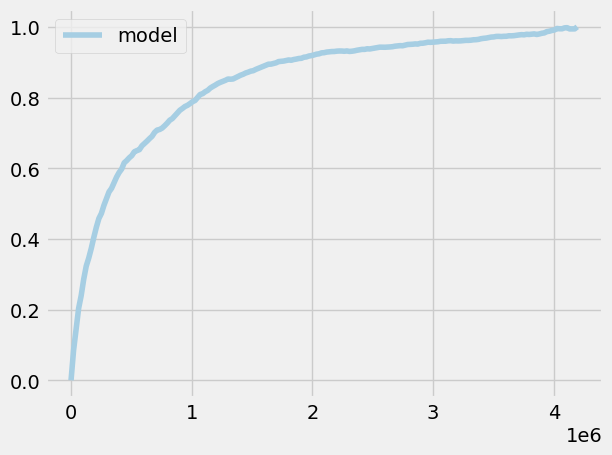

(model    0.845198
dtype: float64,             model
0        0.000000
20969    0.085024
41938    0.145437
62907    0.203710
83876    0.239444
...           ...
4109924  0.997659
4130893  0.994086
4151862  0.994218
4172831  0.994261
4193800  0.999994

[201 rows x 1 columns])
loss = 1.60 * dl + pl
122175/131059 ━━━━━━━━━━━━━━━━━━━━ 6s 766us/step

KeyboardInterrupt: 

In [ ]:
# 存储所有模型的 AUUC 结果
from sklearn import metrics
import numpy as np

def get_auuc_scores(causalml_auuc_list): 
    auuc_scores = []
    for x in causalml_auuc_list:
        auuc_scores.append(x[0].iloc[0])
    return np.array(auuc_scores)

def print_auuc_res(model_name, auuc_scores):
    print("model: ", model_name)
    
    print("auuc list: ", auuc_scores)
    print("auuc mean: ", np.mean(auuc_scores))
    print("auuc variance: ", np.var(auuc_scores))
    print("auuc standard deviation: ", np.std(auuc_scores))
    
    print()

all_auuc_scores = []

alpha = tf.constant([0.8], dtype=tf.float32)

for a in alpha: 
    print(f"loss = {a:.2f} * dl + pl")

    model_file = os.path.join(model_save_dir, f'xxx_{a:.1f}.weights.h5')

    final_model = XXXModel(alpha)
    final_model.load_weights(model_file)

    y_pred_test_all = final_model.predict([X_test, T_test, Y_visit_test])
    y_pred_test_all = np.array(y_pred_test_all)
    selected_output = y_pred_test_all[0]
    print("AUC: ", metrics.roc_auc_score(Y_visit_test, selected_output))
    print("MSE: ", metrics.mean_squared_error(Y_visit_test, selected_output))

    uplift_pred_test = y_pred_test_all[1] - y_pred_test_all[2]

    auuc_score = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=uplift_pred_test)

    print(auuc_score)


../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/xxx_0.8_1.weights.h5
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 96s 731us/step
AUC:  0.8926491532338695
MSE:  0.046319007873535156
model    0.859799
dtype: float64


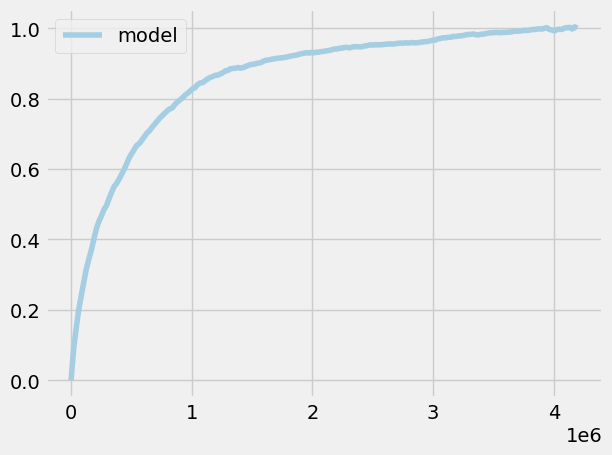

../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/xxx_0.8_2.weights.h5
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 97s 737us/step
AUC:  0.8927594032743584
MSE:  0.04595387727022171
model    0.859246
dtype: float64


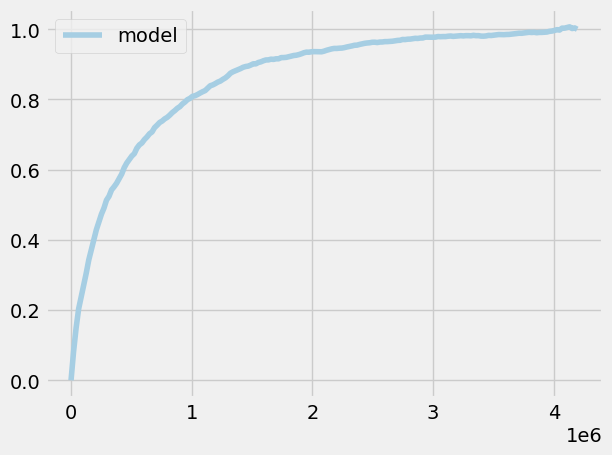

../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/xxx_0.8_3.weights.h5
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 96s 729us/step
AUC:  0.8921236986245761
MSE:  0.04702286422252655
model    0.866076
dtype: float64


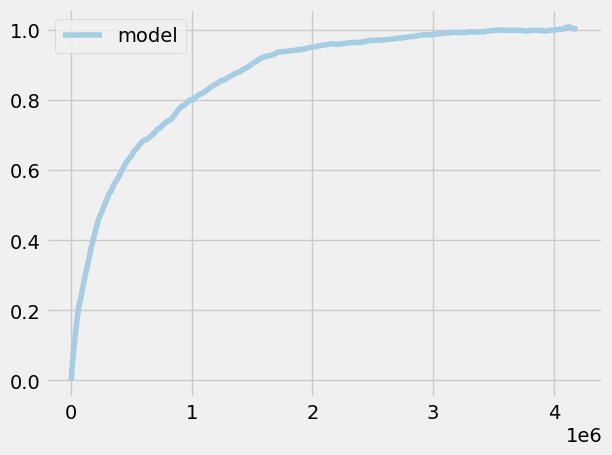

../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/xxx_0.8_6.weights.h5
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 97s 739us/step
AUC:  0.8797593925335375
MSE:  0.0472739040851593
model    0.869073
dtype: float64


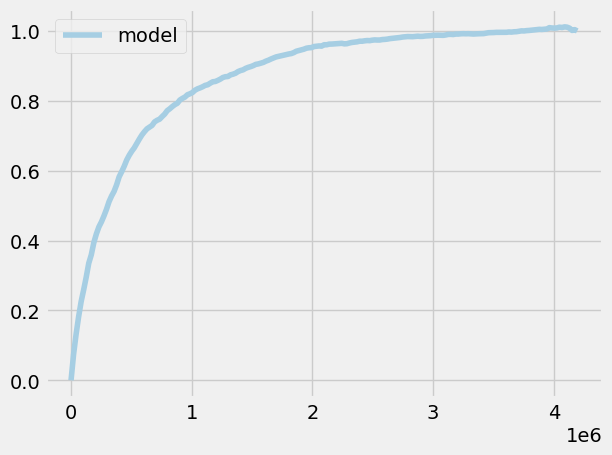

../model_file/uplift/criteo/final_model/my_xxx/v5_total_batch_50w_epoch_1000/xxx_0.8_10.weights.h5
131059/131059 ━━━━━━━━━━━━━━━━━━━━ 93s 706us/step
AUC:  0.8894466564276234
MSE:  0.04801604151725769
model    0.875931
dtype: float64


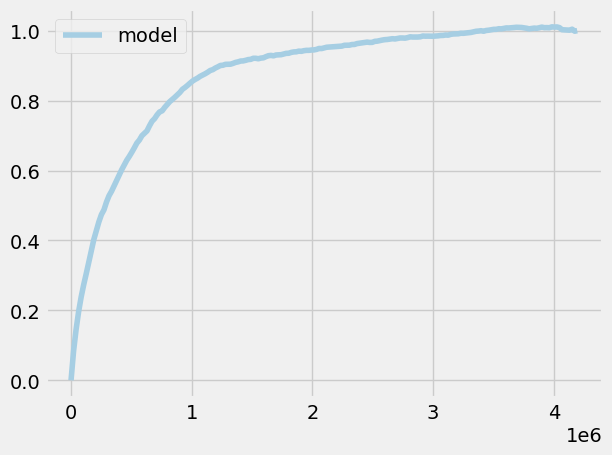

TypeError: unsupported operand type(s) for /: 'type' and 'int'

In [ ]:
# 存储所有模型的 AUUC 结果
from sklearn import metrics
import numpy as np

def get_auuc_scores(causalml_auuc_list): 
    auuc_scores = []
    for x in causalml_auuc_list:
        auuc_scores.append(x[0].iloc[0])
    return np.array(auuc_scores)

def print_auuc_res(model_name, auuc_scores):
    print("model: ", model_name)
    
    print("auuc list: ", auuc_scores)
    print("auuc mean: ", np.mean(auuc_scores))
    print("auuc variance: ", np.var(auuc_scores))
    print("auuc standard deviation: ", np.std(auuc_scores))
    
    print()


all_auuc_scores = []
iters = [1,2,3,6,10]

for i in iters:
    model_file = os.path.join(model_save_dir, f'xxx_0.8_{i}.weights.h5')
    print(model_file)

    final_model = XXXModel(0.8)
    final_model.load_weights(model_file)

    y_pred_test_all = final_model.predict([X_test, T_test, Y_visit_test])
    y_pred_test_all = np.array(y_pred_test_all)
    selected_output = y_pred_test_all[0]
    print("AUC: ", metrics.roc_auc_score(Y_visit_test, selected_output))
    print("MSE: ", metrics.mean_squared_error(Y_visit_test, selected_output))

    uplift_pred_test = y_pred_test_all[1] - y_pred_test_all[2]

    auuc_score = get_causalml_auuc(Y=Y_visit_test, T=T_test, ite_pred=uplift_pred_test)
    all_auuc_scores.append(auuc_score)

xxx_causalml_auuc_list = get_auuc_scores(all_auuc_scores)
#list = list[:-1]
#print(auuc_score)


In [ ]:
import numpy as np

def get_auuc_scores(causalml_auuc_list): 
    auuc_scores = []
    for x in causalml_auuc_list:
        auuc_scores.append(x[0].iloc[0])
    return np.array(auuc_scores)

def print_auuc_res(model_name, auuc_scores):
    print("model: ", model_name)
    
    print("auuc list: ", auuc_scores)
    print("auuc mean: ", np.mean(auuc_scores))
    print("auuc variance: ", np.var(auuc_scores))
    print("auuc standard deviation: ", np.std(auuc_scores))
    
    print()
    
    
def get_avg_uplift_gain(causalml_auuc_list):
    uplift_gain_list = [causalml_auuc[1] for causalml_auuc in causalml_auuc_list]
    avg_uplift_gain = uplift_gain_list[0]
    for uplift_gain in uplift_gain_list[1:]:
        avg_uplift_gain['model'] = avg_uplift_gain['model'] + uplift_gain['model']
    avg_uplift_gain['model'] = avg_uplift_gain['model'] / len(uplift_gain_list)
    
    return avg_uplift_gain

In [ ]:
import pandas as pd

# 使用 Pandas 读取 CSV 文件
slearner_avg_uplift_gain = pd.read_csv('../slearner_avg_uplift_gain.csv')
xlearner_avg_uplift_gain = pd.read_csv('../xlearner_avg_uplift_gain.csv')
grf_avg_uplift_gain = pd.read_csv('../grf_avg_uplift_gain.csv')

xxx_avg_uplift_gain = get_avg_uplift_gain(all_auuc_scores)


In [29]:
xxx_avg_uplift_gain.to_csv("../xxx_avg_uplift_gain.csv")

In [ ]:
print(len(slearner_avg_uplift_gain['model'].values))

201


In [27]:
# test AUUC
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

plt.rc('font',family='Times New Roman') 
# plt.figure(facecolor='white')
# plt.axes(facecolor='white')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth('0.8')

ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth('0.8')

ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth('0.8')


ax.spines['right'].set_visible(True)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth('0.8')


x_index = slearner_avg_uplift_gain.index.to_numpy()

plt.plot(x_index, slearner_avg_uplift_gain['model'].values, color='#FBB454', label='S-Learner', linewidth=1.5)
plt.plot(x_index, xlearner_avg_uplift_gain['model'].values, color='#40a368', label='X-Learner', linewidth=1.5)
plt.plot(x_index, grf_avg_uplift_gain['model'].values, color='#0485d1', label='Causal Forest', linewidth=1.5)
# plt.plot(x_index, DUM_avg_uplift_gain['model'].values, color='#D1512D', label='DUM', linewidth=1.5)
plt.plot(x_index, xxx_avg_uplift_gain['model'].values, color='#D1512D', label='XXX', linewidth=1.5)

plt.plot(x_index, grf_avg_uplift_gain['Random'].values, color='#000000', label='Random', linewidth=1.5)

plt.xlabel('The count of samples', fontsize=12, fontweight='bold')
plt.ylabel('Incremental reward', fontsize=12, fontweight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.xlim(-3e5, 4.5e6)
plt.ylim(-0.05, 1.05)


x_major_locator=MultipleLocator(5e5)
# y_major_locator=MultipleLocator(0.15)
y_major_locator=MultipleLocator(0.2)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)

plt.grid(True)

plt.legend()

os.makedirs('../figure/uplift', exist_ok=True)
#plt.savefig('../figure/uplift/avg_auuc_criteo_new.png', format='png', bbox_inches = 'tight')

plt.show()

RuntimeError: Unable to cast Python instance of type <class 'tuple'> to C++ type '?' (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

<Figure size 640x480 with 1 Axes>